In [1]:
import matplotlib
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import time
# import os.path


from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler



# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def color_hist_forshow(img, nbins=32, bins_range=(0,256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=32, range=(0,256))
    ghist = np.histogram(img[:,:,1], bins=32, range=(0,256))
    bhist = np.histogram(img[:,:,2], bins=32, range=(0,256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

    

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

  
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return  rectangles #draw_img
    

C:\Users\Fido\AppData\Local\conda\conda\envs\tf\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


 
## 1. Preprocess training images

In [2]:
%matplotlib inline

# Load cars and notcars images
car_img = glob.glob('./vehicles/**/*.png')
notcar_img = glob.glob('./non-vehicles/**/*.png')
cars = []
notcars = []
for img in car_img:
    cars.append(img)
for img in notcar_img:
    notcars.append(img)
    
print('nubmer of images of car = ', len(cars))
print('nubmer of images of non-car = ', len(notcars))

nubmer of images of car =  8792
nubmer of images of non-car =  8968


C:\Users\Fido\AppData\Local\conda\conda\envs\tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


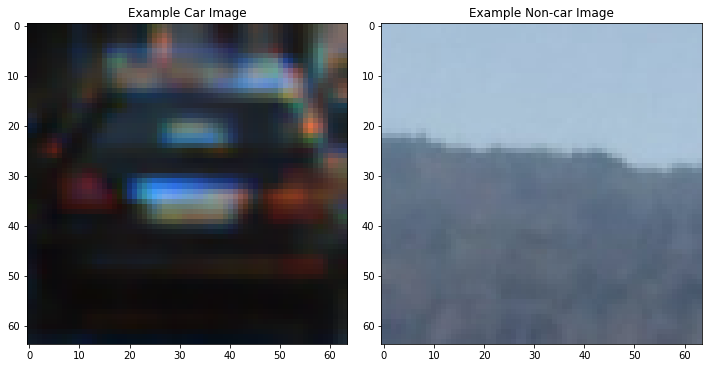

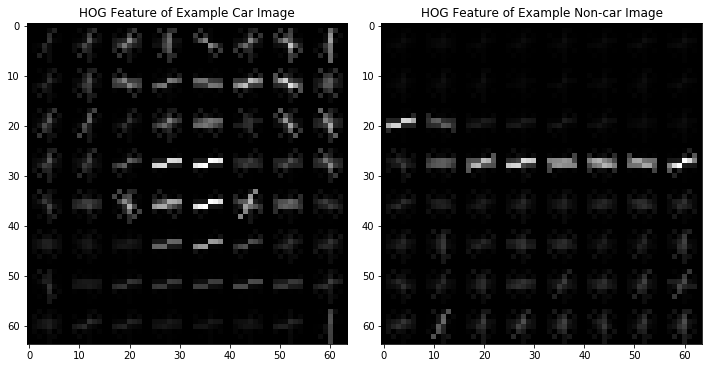

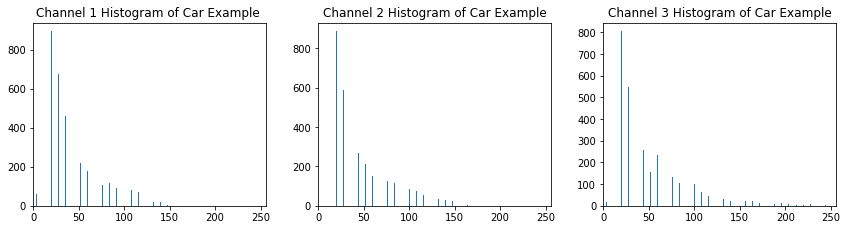

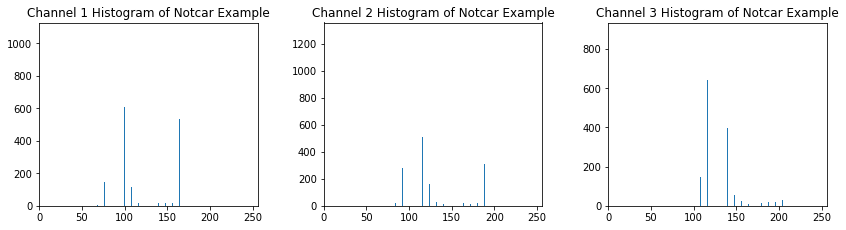

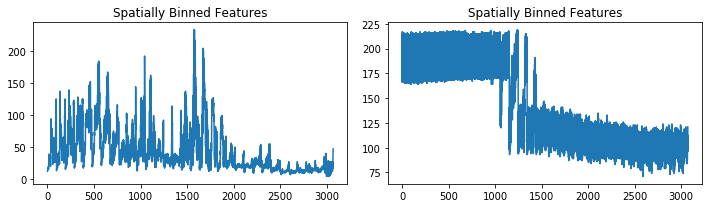

In [3]:
# Characteristic of training images

## Parameters 
### Can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'YCrCb'
### Spatial binning dimensions
spatial_size = (32, 32)  
### Number of histogram bins
hist_bins = 32   
### HOG orientations
orient = 9    
### HOG pixels per cell
pix_per_cell = 8   
### HOG cells per block
cell_per_block = 2  
### Can be 0, 1, 2, or "ALL"
hog_channel = "ALL"       
### Spatial features
spatial_feat = True         
### Histogram features
hist_feat = True            
### HOG features
hog_feat = True    

#y_start_stop = [None, None] # Min and max in y to search in slide_window() 

data_info = data_look(cars, notcars)

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(5, len(cars))
notcar_ind = np.random.randint(50, len(notcars))
    
# Read in car / not-car images
car_img = cv2.imread(cars[car_ind])
car_img = cv2.cvtColor(car_img,cv2.COLOR_BGR2RGB)
car_gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
notcar_img = cv2.imread(notcars[notcar_ind])
notcar_img = cv2.cvtColor(notcar_img,cv2.COLOR_BGR2RGB)
notcar_gray = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2GRAY)

# Color space transformation
#car_img = cv2.cvtColor(car_imgrgb, cv2.COLOR_RGB2YCrCb)
#notcar_img = cv2.cvtColor(notcar_imgrgb, cv2.COLOR_RGB2YCrCb)





# HOG feature of examples
car_featur,hog_car = get_hog_features(car_gray,orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
notcar_featur,hog_notcar = get_hog_features(notcar_gray,orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)


# Histgram of color of car examples
rh_car, gh_car, bh_car, bincen_car, feature_car = color_hist_forshow(car_img, nbins=32, bins_range=(0, 256))
rh_notcar, gh_notcar, bh_notcar, bincen_notcar, feature_notcar = color_hist_forshow(notcar_img, nbins=32, bins_range=(0, 256))


# Spatial binning of examples
bin_spa_car = bin_spatial(car_img, size=(32, 32))
bin_spa_notcar = bin_spatial(notcar_img, size=(32, 32))


# Plot example images in car/non-car groups.
fig = plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(car_img)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_img)
plt.title('Example Non-car Image')
fig.tight_layout()

# Plot HOG feature of examples
fig = plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(hog_car,cmap='gray')
plt.title('HOG Feature of Example Car Image')
plt.subplot(122)
plt.imshow(hog_notcar,cmap='gray')
plt.title('HOG Feature of Example Non-car Image')
fig.tight_layout()

# Plot Histgram of color of car examples
fig = plt.figure(figsize=(12,6))
plt.subplot(231)
plt.bar(bincen_car, rh_car[0])
plt.xlim(0, 256)
plt.title('Channel 1 Histogram of Car Example ')
plt.subplot(232)
plt.bar(bincen_car, gh_car[0])
plt.xlim(0, 256)
plt.title('Channel 2 Histogram of Car Example')
plt.subplot(233)
plt.bar(bincen_car, bh_car[0])
plt.xlim(0, 256)
plt.title('Channel 3 Histogram of Car Example')
fig.tight_layout()

# Plot Histgram of color of non-car examples
fig = plt.figure(figsize=(12,6))
plt.subplot(231)
plt.bar(bincen_notcar, rh_notcar[0])
plt.xlim(0, 256)
plt.title('Channel 1 Histogram of Notcar Example')
plt.subplot(232)
plt.bar(bincen_notcar, gh_notcar[0])
plt.xlim(0, 256)
plt.title('Channel 2 Histogram of Notcar Example')
plt.subplot(233)
plt.bar(bincen_notcar, bh_notcar[0])
plt.xlim(0, 256)
plt.title('Channel 3 Histogram of Notcar Example')
fig.tight_layout()

# Plot spatial binning of examples
fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(bin_spa_car)
plt.title('Spatially Binned Features')
plt.subplot(122)
plt.plot(bin_spa_notcar)
plt.title('Spatially Binned Features')
fig.tight_layout()

### 1.1 Extract Features from Training Images

In [4]:
# Extract features for all training images
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')


C:\Users\Fido\AppData\Local\conda\conda\envs\tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


94.3 Seconds to extract features...


## 2. Normalize Features and Split Training Images

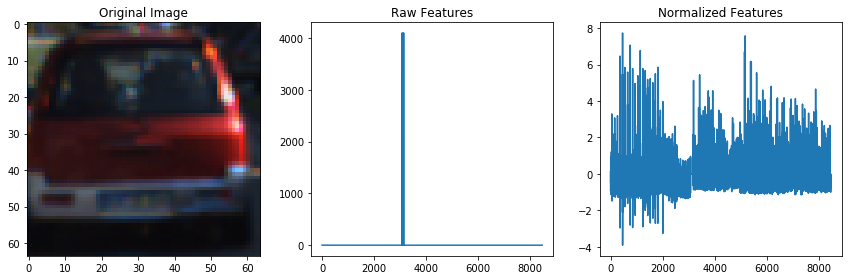

In [5]:

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))


# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()




# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


## 3. Train Classifier

In [6]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

6.53 Seconds to train SVC...
Test Accuracy of SVC =  0.989
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
0.002 Seconds to predict 10 labels with SVC


## 4. Sliding Window Search

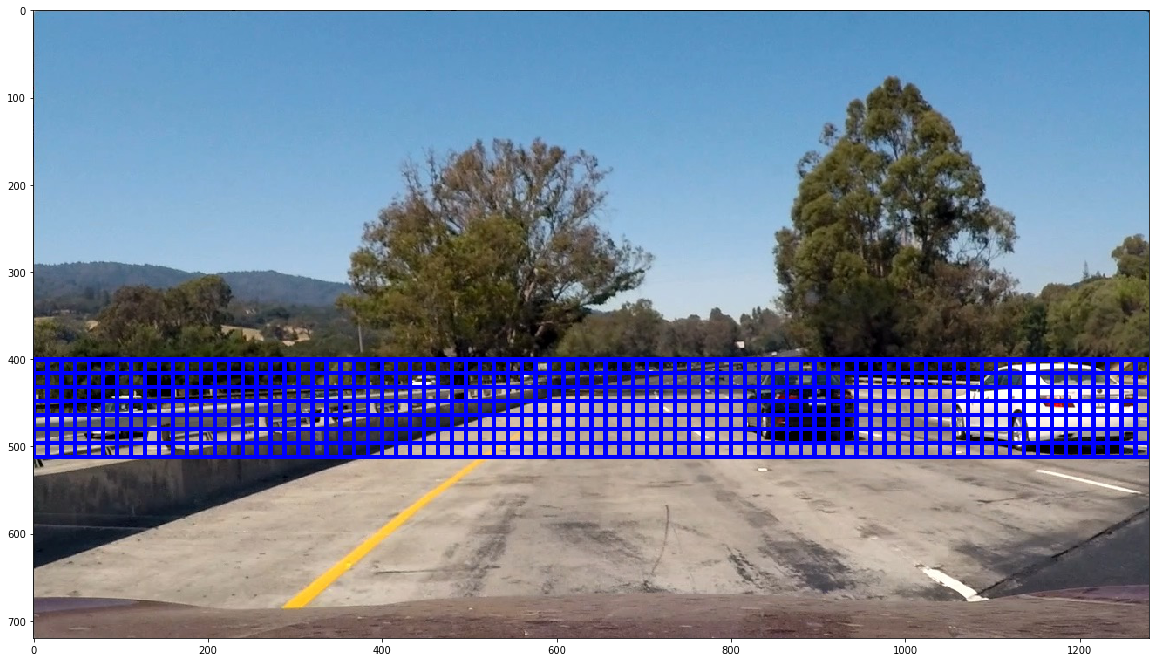

In [36]:
  
test_image = glob.glob('./test_images/*.jpg')
test_img=mpimg.imread(test_image[0])
#test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)

windows=slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 512], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=3)    

fig = plt.figure(figsize=(20,20))
plt.imshow(window_img)




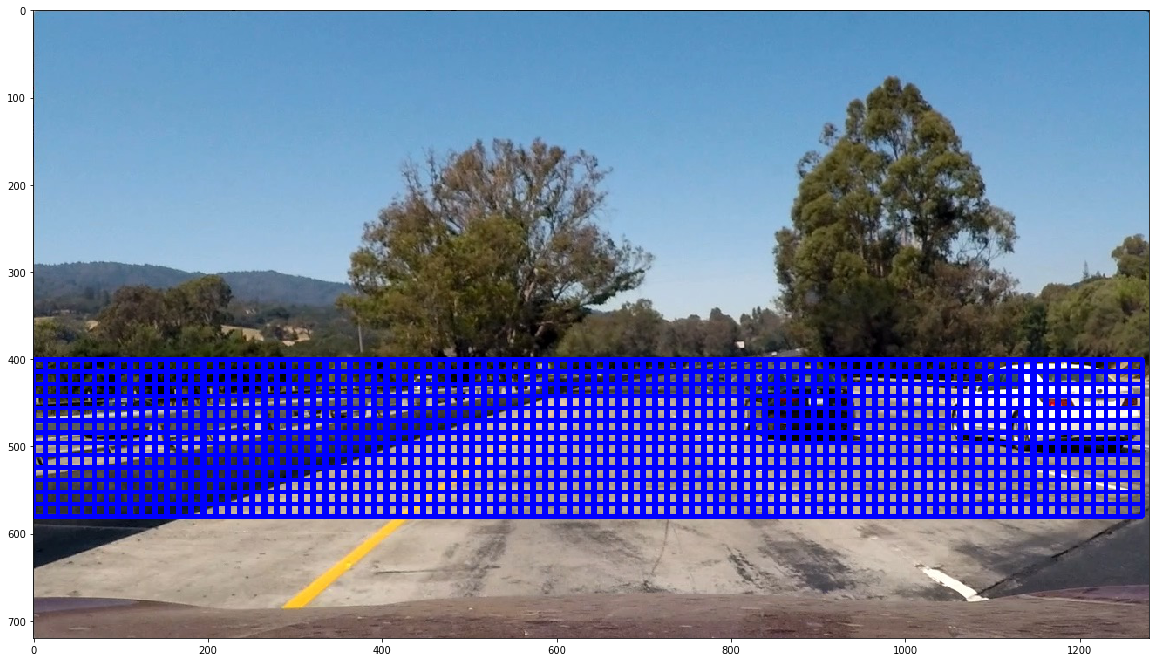

In [37]:
windows=slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 592], 
                    xy_window=(96, 96), xy_overlap=(0.85, 0.85))
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=3)    
fig = plt.figure(figsize=(20,20))
plt.imshow(window_img)

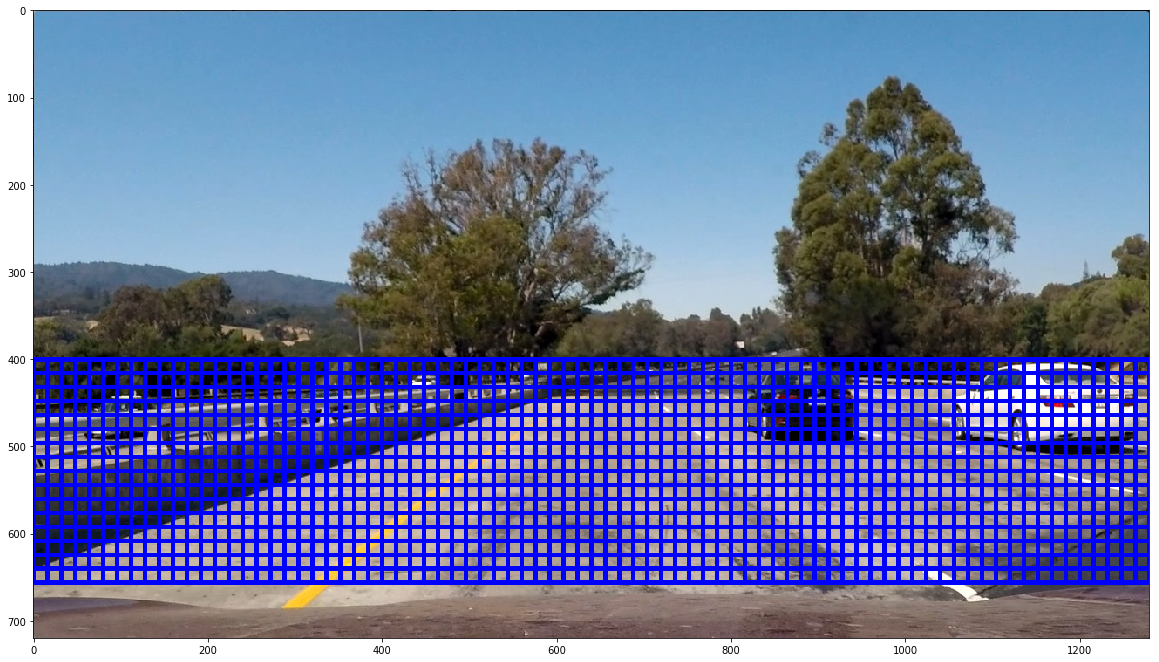

In [32]:
windows=slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 660], 
                    xy_window=(128, 128), xy_overlap=(0.875, 0.875))
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=3)    
fig = plt.figure(figsize=(20,20))
plt.imshow(window_img)

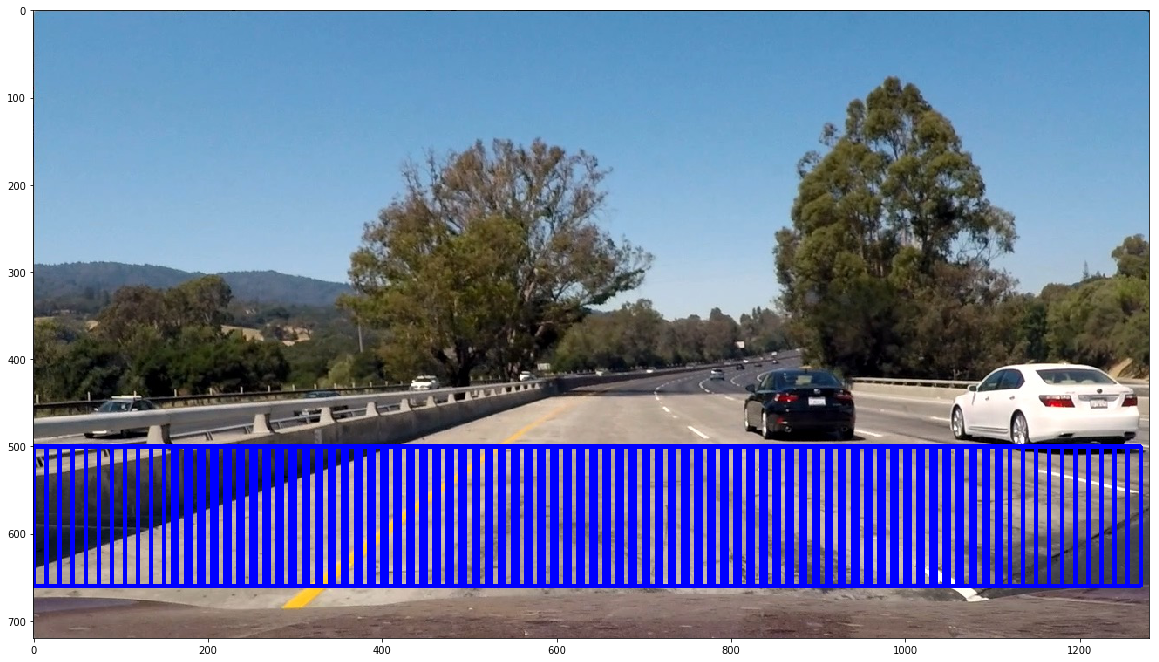

In [35]:
windows=slide_window(test_img, x_start_stop=[None, None], y_start_stop=[500, 660], 
                    xy_window=(160, 160), xy_overlap=(0.9, 0.9))
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=3)    
fig = plt.figure(figsize=(20,20))
plt.imshow(window_img)

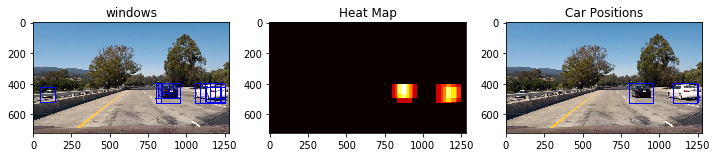

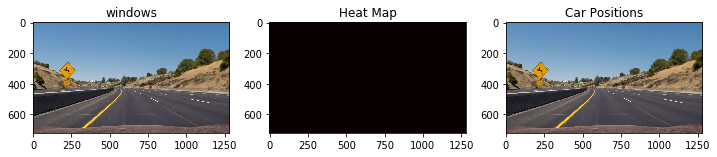

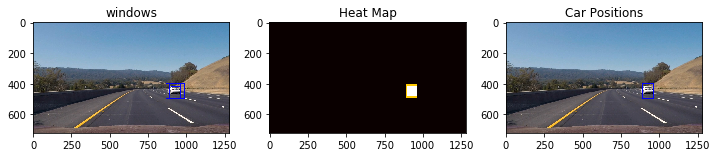

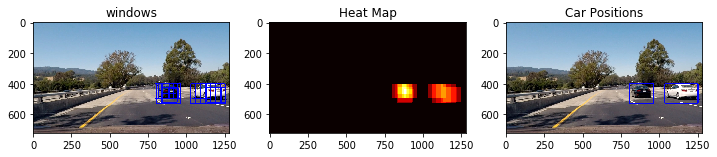

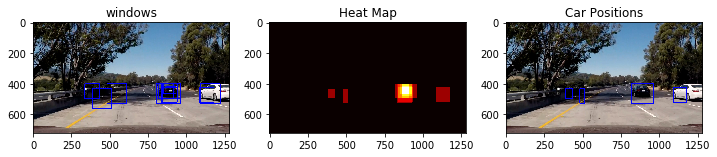

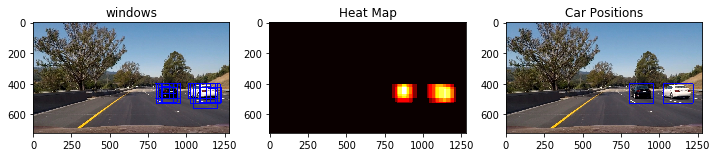

In [61]:
#test_image = glob.glob('./test_images/*.jpg')
#test_img=mpimg.imread(test_image[0])


for test_image in glob.glob("test_images/*.jpg"):

    test_img = mpimg.imread(test_image)



    rect=[]
    ystart=400
    ystop=512
    scale=1
    rect.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart=400
    ystop=592
    scale=1.5
    rect.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart=400
    ystop=660
    scale=2
    rect.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart=500
    ystop=660
    scale=2.5
    rect.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    window_img = draw_boxes(test_img, rect, color=(0, 0, 255), thick=3)    





    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,rect)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

    fig = plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(window_img)
    plt.title('windows')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(133)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    fig.tight_layout()

## Process video

In [7]:
#history=[]

class prev_detection():
    def __init__(self):
        self.history = [] 
    #Only keep history results of last 10 frames
    def add_history(self, rects):
        self.history.append(rects)
        if len(self.history) > 10:
            self.history = self.history[len(self.history)-10:]
            
            
def pipeline(img):
 
    
    rect=[]
   
  
    ystart=400
    ystop=576
    scale=1
    rect.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(rect)
    ystart=400
    ystop=660
    scale=1.5
    rect.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(rect)
    ystart=400
    ystop=660
    scale=2
    rect.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(rect)
    ystart=500
    ystop=660
    scale=2.5
    rect.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

      
 

    # add detected results to the history
    if len(rect) > 0:
        his.add_history(rect)    
        


    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat 
    for his_rects in his.history:
        heat= add_heat(heat, his_rects)
    
    
    # Apply threshold 
    heat = apply_threshold(heat,1+ len(his.history)//2)

    # Visualize the heatmap   
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    

    return draw_img




In [8]:
from imageio.plugins import ffmpeg
from moviepy.editor import VideoFileClip


his=prev_detection()

proj_video_out = './project_video_out.mp4'
proj_clip = VideoFileClip('./project_video.mp4')  
proj_clip_out = proj_clip.fl_image(pipeline)
%time proj_clip_out.write_videofile(proj_video_out, audio=False)

[MoviePy] >>>> Building video ./project_video_out2.mp4
[MoviePy] Writing video ./project_video_out2.mp4


100%|█████████████████████████████████████▉| 1260/1261 [28:08<00:01,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out2.mp4 

Wall time: 28min 8s
